In [1]:
## Megan getting errors with Yoni script src folder 
# copy and pasting functions here 

# script goal - use mediapipe world outputs to estimate depth in meters 

In [2]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

In [3]:
#from src.analysis_funs import get_landmark_pairs, get_all_unique_pairs
def get_all_unique_pairs(df):
    df_pairs = df.merge(df, on='frame', how='left')
    df_pairs = df_pairs[df_pairs['label_x'] != df_pairs['label_y']]
    def make_id(x, y, i):
        return str(i) + "-" +  str(max(x,y)) + "-" + str(min(x,y))
    df_pairs["row_id"] = df_pairs.apply(lambda row: make_id(row["subframe_id_x"],
                                                                row["subframe_id_y"],
                                                                row["frame"]), axis=1)
    return df_pairs.drop_duplicates(subset="row_id", keep="first")


def get_landmark_pairs(landmark_df, label_x, label_y):
    tmp = landmark_df.merge(landmark_df, on='frame', how='left')
    return tmp[(tmp.label_x == label_x) & (tmp.label_y == label_y)].copy()

In [4]:
output_path = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\test_velocity_01302025\hc_video_output\DS_HC\2024-05-02\000_raw_pose_data'
csv_file_name = 'mari_mpipe_gait_vertical_left_df.csv'
png_file_name = 'mari_mpipe_gait_vertical_left_df.png'

mpipe_path = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\test_velocity_01302025\hc_video_output\DS_HC\2024-05-02\000_raw_pose_data\gait_vertical_left_mediapipe_world.csv'
mari_path = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\test_velocity_01302025\hc_video_output\DS_HC\2024-05-02\000_raw_pose_data\gait_vertical_left_marigold.csv'
yolo_path = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\test_velocity_01302025\hc_video_output\DS_HC\2024-05-02\000_raw_pose_data\gait_vertical_left_yolo.csv'

## Calculate hip width as true distance change

In [5]:
# hip width in pixels 
yolo_df = pd.read_csv(yolo_path, index_col = 0) 
r_hip_yolo_df = yolo_df.loc[yolo_df['label'] == 'right_hip']
r_hip_yolo_df.set_index('frame', inplace=True)
l_hip_yolo_df = yolo_df.loc[yolo_df['label'] == 'left_hip']
l_hip_yolo_df.set_index('frame', inplace=True)
r_hip_yolo_df.head()

l_hip_yolo_df = l_hip_yolo_df.copy()
l_hip_yolo_df.loc[:, 'hip_width_x'] = abs(r_hip_yolo_df['X'] - l_hip_yolo_df['X']).rolling(window=10, min_periods = 1).mean()

l_hip_yolo_df.head()

,X,Y,label,hip_width_x
frame,,,,
0,711.20340,1120.2400,left_hip,690.283800
1,747.09247,1133.5638,left_hip,669.658715
2,721.14660,1114.1898,left_hip,679.838677
3,724.84937,1125.1664,left_hip,681.423915
4,724.66880,1110.2170,left_hip,684.114132


## Create meters/depth conversion ratio 

In [6]:
# mediapipe world landmarks 
mpipe = pd.read_csv(mpipe_path)

mpipe = mpipe.rename(columns={'Unnamed: 0': 'subframe_id'})
mpipe_filt = mpipe[mpipe['label'].notnull()]

mpipe_pairs = get_all_unique_pairs(mpipe_filt)
mpipe_pairs.head()

,subframe_id_x,X_x,Y_x,Z_x,vis_x,pres_x,frame,label_x,subframe_id_y,X_y,Y_y,Z_y,vis_y,pres_y,label_y,row_id
1,0,0.051472,-0.445183,-0.139982,0.988839,0.0,21,nose,1,0.067753,-0.472915,-0.144262,0.973599,0.0,left_eye_inner,21-1-0
2,0,0.051472,-0.445183,-0.139982,0.988839,0.0,21,nose,2,0.067989,-0.473360,-0.143249,0.967595,0.0,left_eye,21-2-0
3,0,0.051472,-0.445183,-0.139982,0.988839,0.0,21,nose,3,0.068057,-0.473352,-0.143694,0.977638,0.0,left_eye_outer,21-3-0
4,0,0.051472,-0.445183,-0.139982,0.988839,0.0,21,nose,4,0.041102,-0.471120,-0.144715,0.977076,0.0,right_eye_inner,21-4-0
5,0,0.051472,-0.445183,-0.139982,0.988839,0.0,21,nose,5,0.041411,-0.471803,-0.145436,0.969528,0.0,right_eye,21-5-0


In [7]:
# marigold depth estimates 
mari = pd.read_csv(mari_path)

mari = mari.rename(columns={'Unnamed: 0': 'subframe_id'})
mari_filt = mari[mari['label'].notnull()]

mari_pairs = get_all_unique_pairs(mari_filt)
mari_pairs.head()

,subframe_id_x,frame,label_x,depth_est_x,subframe_id_y,label_y,depth_est_y,row_id
1,0,30,nose,0.088482,1,left_eye_inner,0.082858,30-1-0
2,0,30,nose,0.088482,2,left_eye,0.082643,30-2-0
3,0,30,nose,0.088482,3,left_eye_outer,0.079664,30-3-0
4,0,30,nose,0.088482,4,right_eye_inner,0.088238,30-4-0
5,0,30,nose,0.088482,5,right_eye,0.087943,30-5-0


In [8]:
# merge marigold and mediapipe pairs 
mari_mpipe = mari_pairs.merge(mpipe_pairs, on=['frame', 'row_id'])
print(f"mari_pipe type: {type(mari_mpipe)}")
mari_mpipe.head()

mari_pipe type: <class 'pandas.core.frame.DataFrame'>


,subframe_id_x_x,frame,label_x_x,depth_est_x,subframe_id_y_x,label_y_x,depth_est_y,row_id,subframe_id_x_y,X_x,...,vis_x,pres_x,label_x_y,subframe_id_y_y,X_y,Y_y,Z_y,vis_y,pres_y,label_y_y
0,0,30,nose,0.088482,1,left_eye_inner,0.082858,30-1-0,0,-0.475964,...,0.971166,0.0,nose,1,-0.497497,-0.145824,0.145978,0.969387,0.0,left_eye_inner
1,0,30,nose,0.088482,2,left_eye,0.082643,30-2-0,0,-0.475964,...,0.971166,0.0,nose,2,-0.497745,-0.145864,0.146885,0.963271,0.0,left_eye
2,0,30,nose,0.088482,3,left_eye_outer,0.079664,30-3-0,0,-0.475964,...,0.971166,0.0,nose,3,-0.498418,-0.145661,0.147273,0.971850,0.0,left_eye_outer
3,0,30,nose,0.088482,4,right_eye_inner,0.088238,30-4-0,0,-0.475964,...,0.971166,0.0,nose,4,-0.481212,-0.170805,0.145949,0.971480,0.0,right_eye_inner
4,0,30,nose,0.088482,5,right_eye,0.087943,30-5-0,0,-0.475964,...,0.971166,0.0,nose,5,-0.481791,-0.171079,0.145127,0.963453,0.0,right_eye


In [9]:
def check_row(labxx,labyx,labxy,labyy):
    return (labxx == labxy) and (labyx == labyy)


mari_mpipe["label_agreement"] = mari_mpipe.apply(lambda row: check_row(row["label_x_x"],
                                                                       row["label_y_x"],
                                                                       row["label_x_y"],
                                                                       row["label_y_y"]),
                                                 axis=1)
mari_mpipe.head()

,subframe_id_x_x,frame,label_x_x,depth_est_x,subframe_id_y_x,label_y_x,depth_est_y,row_id,subframe_id_x_y,X_x,...,pres_x,label_x_y,subframe_id_y_y,X_y,Y_y,Z_y,vis_y,pres_y,label_y_y,label_agreement
0,0,30,nose,0.088482,1,left_eye_inner,0.082858,30-1-0,0,-0.475964,...,0.0,nose,1,-0.497497,-0.145824,0.145978,0.969387,0.0,left_eye_inner,True
1,0,30,nose,0.088482,2,left_eye,0.082643,30-2-0,0,-0.475964,...,0.0,nose,2,-0.497745,-0.145864,0.146885,0.963271,0.0,left_eye,True
2,0,30,nose,0.088482,3,left_eye_outer,0.079664,30-3-0,0,-0.475964,...,0.0,nose,3,-0.498418,-0.145661,0.147273,0.971850,0.0,left_eye_outer,True
3,0,30,nose,0.088482,4,right_eye_inner,0.088238,30-4-0,0,-0.475964,...,0.0,nose,4,-0.481212,-0.170805,0.145949,0.971480,0.0,right_eye_inner,True
4,0,30,nose,0.088482,5,right_eye,0.087943,30-5-0,0,-0.475964,...,0.0,nose,5,-0.481791,-0.171079,0.145127,0.963453,0.0,right_eye,True


In [10]:
# depth_to_m: conversion of mediapipe Z depth / marigold depth est 
# for each row: (mediapipe Z world distance between the two landmarks) / (marigold depth diff between the two landmarks) 
mari_mpipe["depth_to_m"] = np.abs(mari_mpipe["Z_x"] - mari_mpipe["Z_y"]) / np.abs(mari_mpipe["depth_est_x"] - mari_mpipe["depth_est_y"])
mari_mpipe.head()

,subframe_id_x_x,frame,label_x_x,depth_est_x,subframe_id_y_x,label_y_x,depth_est_y,row_id,subframe_id_x_y,X_x,...,label_x_y,subframe_id_y_y,X_y,Y_y,Z_y,vis_y,pres_y,label_y_y,label_agreement,depth_to_m
0,0,30,nose,0.088482,1,left_eye_inner,0.082858,30-1-0,0,-0.475964,...,nose,1,-0.497497,-0.145824,0.145978,0.969387,0.0,left_eye_inner,True,2.559326
1,0,30,nose,0.088482,2,left_eye,0.082643,30-2-0,0,-0.475964,...,nose,2,-0.497745,-0.145864,0.146885,0.963271,0.0,left_eye,True,2.309682
2,0,30,nose,0.088482,3,left_eye_outer,0.079664,30-3-0,0,-0.475964,...,nose,3,-0.498418,-0.145661,0.147273,0.971850,0.0,left_eye_outer,True,1.485503
3,0,30,nose,0.088482,4,right_eye_inner,0.088238,30-4-0,0,-0.475964,...,nose,4,-0.481212,-0.170805,0.145949,0.971480,0.0,right_eye_inner,True,59.053691
4,0,30,nose,0.088482,5,right_eye,0.087943,30-5-0,0,-0.475964,...,nose,5,-0.481791,-0.171079,0.145127,0.963453,0.0,right_eye,True,28.318898


In [11]:
mari_mpipe.to_csv(os.path.join(output_path, csv_file_name)) 

In [35]:
# median conversion factor at each frame 
convert_depth = mari_mpipe.groupby(['frame'])['depth_to_m'].median()
convert_depth_df = pd.DataFrame(convert_depth)
convert_depth_df = convert_depth_df.rename(columns = {'depth_to_m' : 'median_depth_to_m'})

In [36]:
# new - tyring median conversion factor across all frames 
convert_depth_df['median_depth_to_m_allframes'] = mari_mpipe['depth_to_m'].median()
convert_depth_df.head()

,median_depth_to_m,median_depth_to_m_allframes
frame,,
30,3.367730,4.723199
60,3.586316,4.723199
90,4.545044,4.723199
120,3.454683,4.723199
150,3.570237,4.723199


## on same axis as depth_to_m --> smooth depth_to_m

In [37]:
convert_depth_df['smoothed_median_depth_to_m'] = convert_depth_df['median_depth_to_m'].rolling(window=3, min_periods = 1).mean()
convert_depth_df.head()

,median_depth_to_m,median_depth_to_m_allframes,smoothed_median_depth_to_m
frame,,,
30,3.367730,4.723199,3.367730
60,3.586316,4.723199,3.477023
90,4.545044,4.723199,3.833030
120,3.454683,4.723199,3.862014
150,3.570237,4.723199,3.856655


## Estimate depth = (marigold depth median of all landmarks) * (smoothed - depth_to_m - median at each frame) 

In [41]:
#median depth estimate for each frame 
convert_depth_df['median_mari_depth_est'] = mari_mpipe.groupby(['frame'])['depth_est_x'].median()
convert_depth_df.head()

convert_depth_df['meter_depth_est'] = convert_depth_df['median_mari_depth_est'] * convert_depth_df['median_depth_to_m']
convert_depth_df['meter_depth_est_smooth'] = convert_depth_df['median_mari_depth_est'] * convert_depth_df['smoothed_median_depth_to_m']

# new 2/11/2024 
convert_depth_df['meter_depth_est_2'] = convert_depth_df['median_mari_depth_est'] * convert_depth_all_frames

convert_depth_df.head()

,median_depth_to_m,median_depth_to_m_allframes,smoothed_median_depth_to_m,median_mari_depth_est,meter_depth_est,meter_depth_est_smooth,meter_depth_est_2
frame,,,,,,,
30,3.367730,4.723199,3.367730,0.082643,0.278318,0.278318,0.390337
60,3.586316,4.723199,3.477023,0.103774,0.372165,0.360823,0.490144
90,4.545044,4.723199,3.833030,0.079765,0.362534,0.305741,0.376745
120,3.454683,4.723199,3.862014,0.143797,0.496772,0.555345,0.679180
150,3.570237,4.723199,3.856655,0.135255,0.482893,0.521633,0.638837


In [42]:
# raw 
print(f"max feet depth est: {convert_depth_df['meter_depth_est'].max() * 3.28}")
print(f"min feet depth est: {convert_depth_df['meter_depth_est'].min() * 3.28}")

# smoothed 
#print('smoothed') 
#print(f"max feet depth est: {convert_depth_df['meter_depth_est_smooth'].max() * 3.28}")
#print(f"min feet depth est: {convert_depth_df['meter_depth_est_smooth'].min() * 3.28}")

max feet depth est: 9.489167347633034
min feet depth est: 0.3085896326075103


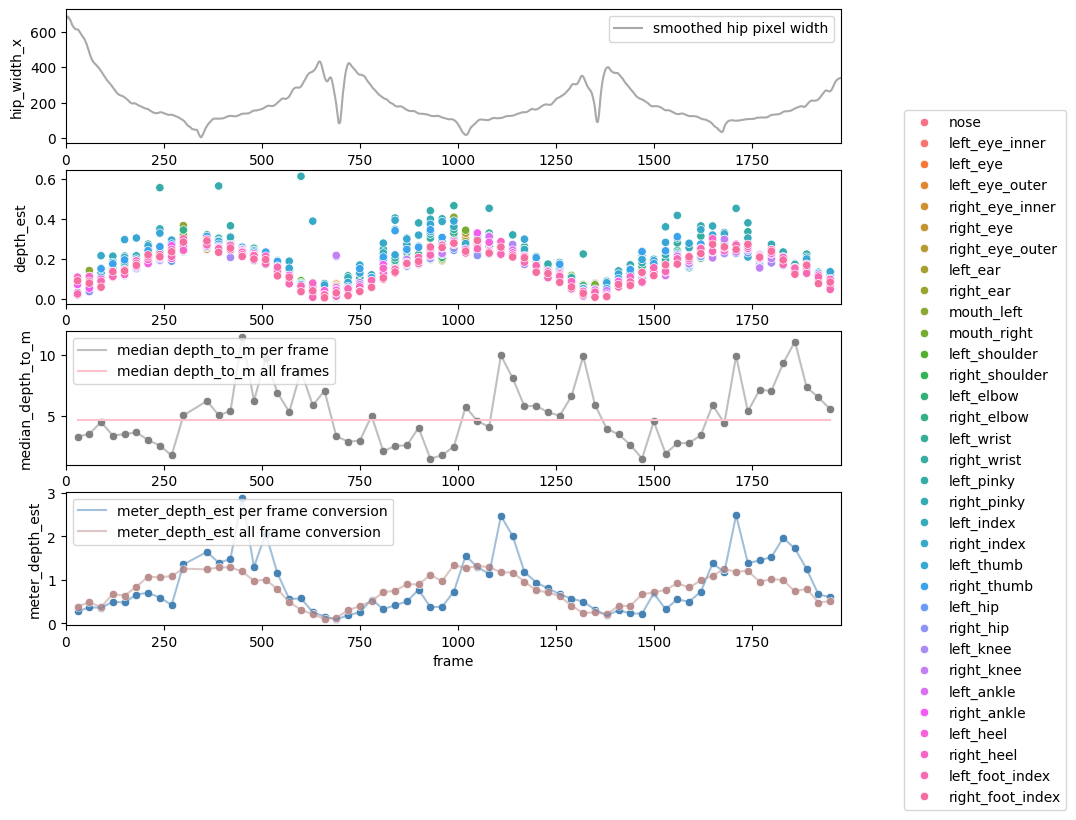

In [48]:
# plot 
max_frame = yolo_df['frame'].max()

fig, axs = plt.subplots(4, 1, figsize=(10, 8))
# hip width data 
sns.lineplot(x = 'frame', y = 'hip_width_x', data = l_hip_yolo_df, color = 'darkgrey', label = 'smoothed hip pixel width', ax = axs[0])
axs[0].legend(loc = 'upper right')
axs[0].set_xlim(0, max_frame) 

# raw depth data 
sns.scatterplot(x = 'frame', y = 'depth_est', hue = 'label', data = mari, ax = axs[1])
axs[1].set_xlim(0, max_frame) 
axs[1].legend(loc = 'upper right', bbox_to_anchor=(1.3, 1.5))

# depth to meter conversion unit 
# old -----
sns.scatterplot(x = 'frame', y = 'median_depth_to_m', data = convert_depth_df, color = 'grey', ax = axs[2])
# depth to meter, smoothed 
# sns.scatterplot(x = 'frame', y = 'smoothed_median_depth_to_m', data = convert_depth_df, color = 'teal', ax = axs[2])
sns.lineplot(x = 'frame', y = 'median_depth_to_m', data = convert_depth_df, 
             alpha = 0.5,
             color = 'grey', label = 'median depth_to_m per frame', ax = axs[2])
#sns.lineplot(x = 'frame', y = 'smoothed_median_depth_to_m', data = convert_depth_df, 
          #   alpha = 0.5,
          #   color = 'teal', label = 'smoothed median_depth_to_m', ax = axs[2])
axs[2].set_xlim(0, max_frame) 

# new -----
sns.lineplot(x = 'frame', y = 'median_depth_to_m_allframes', data = convert_depth_df, color = 'pink', label = 'median depth_to_m all frames',
                ax = axs[2])
# ------

# plot depth estimate 
sns.scatterplot(x = 'frame', y = 'meter_depth_est', data = convert_depth_df, color = 'steelblue', ax = axs[3])
sns.scatterplot(x = 'frame', y = 'meter_depth_est_2', data = convert_depth_df, color = 'rosybrown', ax = axs[3])

sns.lineplot(x = 'frame', y = 'meter_depth_est', data = convert_depth_df, 
             alpha = 0.5,
             color = 'steelblue', label = 'meter_depth_est per frame conversion', ax = axs[3])
sns.lineplot(x = 'frame', y = 'meter_depth_est_2', data = convert_depth_df, 
             alpha = 0.5,
             color = 'rosybrown', label = 'meter_depth_est all frame conversion', ax = axs[3])
axs[3].set_xlim(0, max_frame) 
plt.show()

In [49]:
fig.savefig(os.path.join(output_path, png_file_name),bbox_inches ='tight')

In [18]:
# to do - plot each landmark conversion median as a row one color 